In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,f1_score, confusion_matrix, precision_recall_curve, average_precision_score, roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.model_selection import GridSearchCV

In [2]:
# Ensure plots appear within the notebook
%matplotlib inline

# Display float values nicely
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Load the dataset
print("Loading dataset...")
df = pd.read_csv("paysim_dataset1m.csv")
print("Dataset loaded successfully!\n")

Loading dataset...
Dataset loaded successfully!



In [3]:
# Quick overview of the dataset
print(f"The dataset has {df.shape[0]:,} rows and {df.shape[1]} columns.\n")
df.info()


The dataset has 99,999 rows and 11 columns.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            99999 non-null  int64  
 1   type            99999 non-null  object 
 2   amount          99999 non-null  float64
 3   nameOrig        99999 non-null  object 
 4   oldbalanceOrg   99999 non-null  float64
 5   newbalanceOrig  99999 non-null  float64
 6   nameDest        99999 non-null  object 
 7   oldbalanceDest  99999 non-null  float64
 8   newbalanceDest  99999 non-null  float64
 9   isFraud         99999 non-null  int64  
 10  isFlaggedFraud  99999 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 8.4+ MB


In [4]:
# Preview the first few rows
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0


In [5]:
# Exploratory Data Analysis (EDA)

# Check for missing values
print("\nChecking for missing values:")
print(df.isnull().sum())


Checking for missing values:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [6]:
# Data types and number of unique values per column
df.nunique().sort_values()

isFlaggedFraud        1
isFraud               2
type                  5
step                 10
newbalanceDest    18759
newbalanceOrig    46427
nameDest          51550
oldbalanceDest    51976
oldbalanceOrg     56389
amount            99469
nameOrig          99999
dtype: int64

Fraud Class Distribution:

isFraud
0    99883
1      116
Name: count, dtype: int64

Percentage Distribution:

isFraud
0   99.88
1    0.12
Name: proportion, dtype: float64


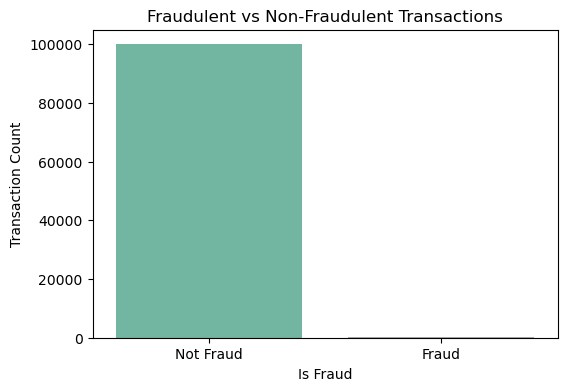

In [7]:


# Count of fraudulent vs non-fraudulent transactions
fraud_counts = df['isFraud'].value_counts()
fraud_percent = df['isFraud'].value_counts(normalize=True) * 100

print("Fraud Class Distribution:\n")
print(fraud_counts)
print("\nPercentage Distribution:\n")
print(fraud_percent)

# Plot the distribution
plt.figure(figsize=(6,4))
sns.countplot(x='isFraud', data=df, palette='Set2')
plt.title('Fraudulent vs Non-Fraudulent Transactions')
plt.xlabel('Is Fraud')
plt.ylabel('Transaction Count')
plt.xticks([0, 1], ['Not Fraud', 'Fraud'])
plt.show()


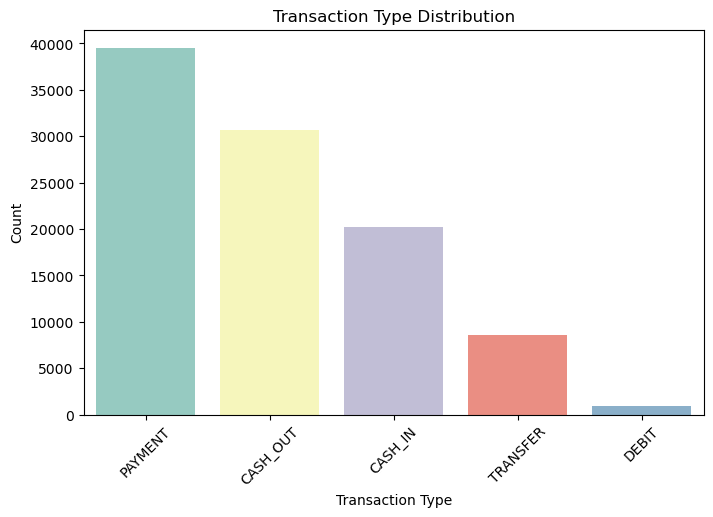

isFraud,0,1
type,,
CASH_IN,100.00,0.00
CASH_OUT,99.81,0.19
DEBIT,100.00,0.00
PAYMENT,100.00,0.00
TRANSFER,99.34,0.66


In [8]:
# Frequency of each transaction type
plt.figure(figsize=(8,5))
sns.countplot(x='type', data=df, order=df['type'].value_counts().index, palette='Set3')
plt.title('Transaction Type Distribution')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Cross-tab between transaction type and fraud
pd.crosstab(df['type'], df['isFraud'], normalize='index') * 100

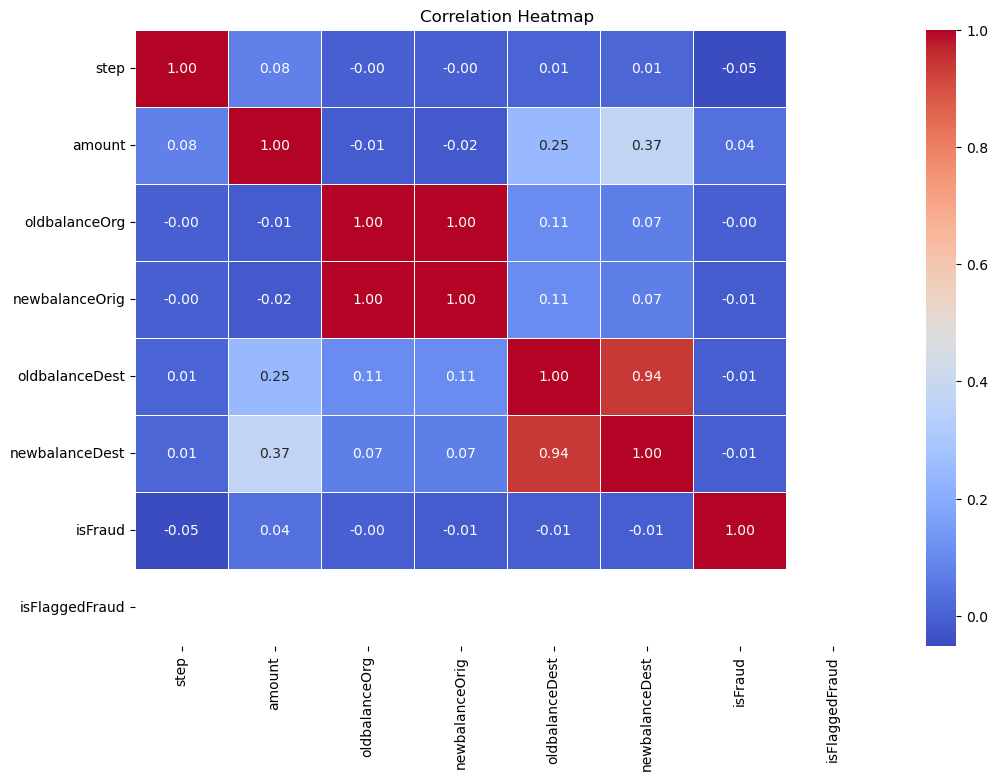

In [9]:
# Only numerical features
numerical_df = df.select_dtypes(include=np.number)

# Compute correlation matrix
corr = numerical_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

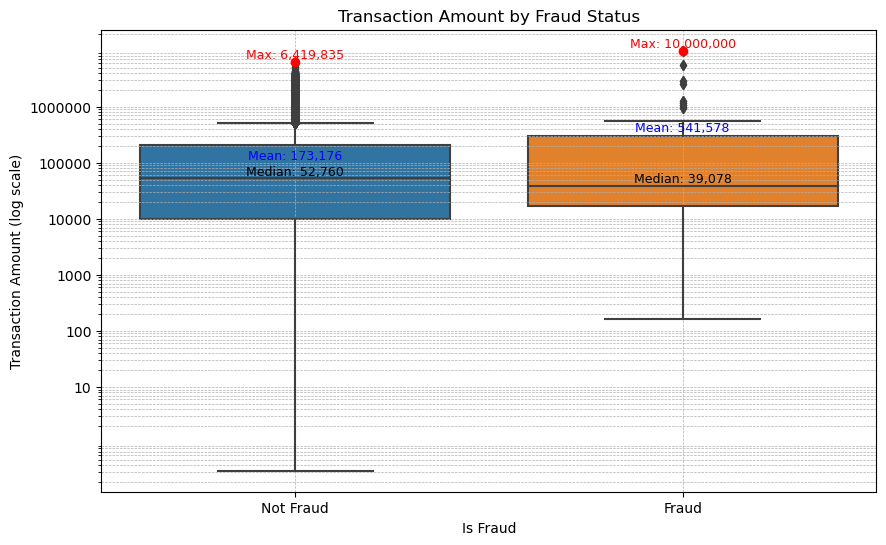

In [10]:
plt.figure(figsize=(10,6))
sns.boxplot(x='isFraud', y='amount', data=df)
plt.yscale('log')

# Set log-scale ticks
ticks = [10, 100, 1000, 10000, 100000, 1000000]
plt.yticks(ticks, [str(tick) for tick in ticks])

# Group data
grouped = df.groupby('isFraud')['amount']
medians = grouped.median()
means = grouped.mean()
max_values = grouped.max()

for i in range(len(medians)):
    # Median label (below)
    plt.text(i, medians[i], f'Median: {medians[i]:,.0f}',
             ha='center', va='bottom', fontsize=9, color='black')

    # Mean label (above)
    plt.text(i, means[i], f'Mean: {means[i]:,.0f}',
             ha='center', va='top', fontsize=9, color='blue')

    # Max value as red dot and label
    plt.plot(i, max_values[i], 'ro')  # Red dot
    plt.text(i, max_values[i], f'Max: {max_values[i]:,.0f}',
             ha='center', va='bottom', fontsize=9, color='red')

plt.title("Transaction Amount by Fraud Status")
plt.xlabel("Is Fraud")
plt.ylabel("Transaction Amount (log scale)")
plt.xticks([0, 1], ['Not Fraud', 'Fraud'])
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

plt.show()


In [11]:
# Data Preprocessing

# Drop columns that aren't useful for the model
df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1, inplace=True)

In [12]:
# Label encode the 'type' column (transaction type)
df['type'] = LabelEncoder().fit_transform(df['type'])

In [13]:
# Split the data into features (X) and target (y)
X = df.drop('isFraud', axis=1)
y = df['isFraud']

In [14]:
# Standardize the feature values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into train and test sets (30% test, 70% train)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

In [15]:
def evaluate_model(y_true, y_pred, y_proba=None, model_name="Model"):
    print(f"Evaluation Report: {model_name}\n")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, digits=4))

    if y_proba is not None:
        auc_score = roc_auc_score(y_true, y_proba)
        print(f"ROC-AUC Score: {auc_score:.4f}")
        RocCurveDisplay.from_predictions(y_true, y_proba)

Evaluation Report: Random Forest

[[29964     1]
 [   19    16]]

Classification Report:

              precision    recall  f1-score   support

           0     0.9994    1.0000    0.9997     29965
           1     0.9412    0.4571    0.6154        35

    accuracy                         0.9993     30000
   macro avg     0.9703    0.7286    0.8075     30000
weighted avg     0.9993    0.9993    0.9992     30000

ROC-AUC Score: 0.9558


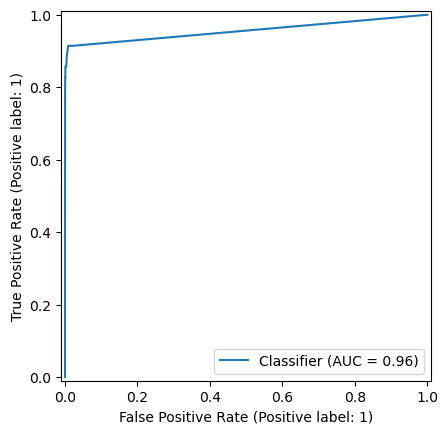

In [16]:
# Model Training & Evaluation
# --- 1. Random Forest ---

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluate
evaluate_model(y_test, y_pred_rf, y_proba_rf, model_name="Random Forest")

In [17]:
# Define parameter grid
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']
}

# Initialize base model
rf_base = RandomForestClassifier(random_state=42)

# Set up Grid Search
rf_grid = GridSearchCV(estimator=rf_base, param_grid=rf_param_grid,
                       scoring='f1', cv=3, verbose=2, n_jobs=-1)

# Fit to training data
rf_grid.fit(X_train, y_train)

# Best model
rf_model = rf_grid.best_estimator_
print("Best Parameters for Random Forest:\n", rf_grid.best_params_)

# Predict and Evaluate
rf_preds = rf_model.predict(X_test)
rf_probs = rf_model.predict_proba(X_test)[:, 1]


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters for Random Forest:
 {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}


=== Random Forest Results ===
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9997     29965
           1     0.8462    0.6286    0.7213        35

    accuracy                         0.9994     30000
   macro avg     0.9229    0.8142    0.8605     30000
weighted avg     0.9994    0.9994    0.9994     30000



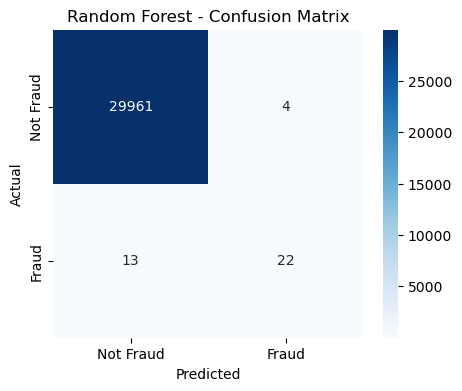

ROC-AUC Score: 0.9895


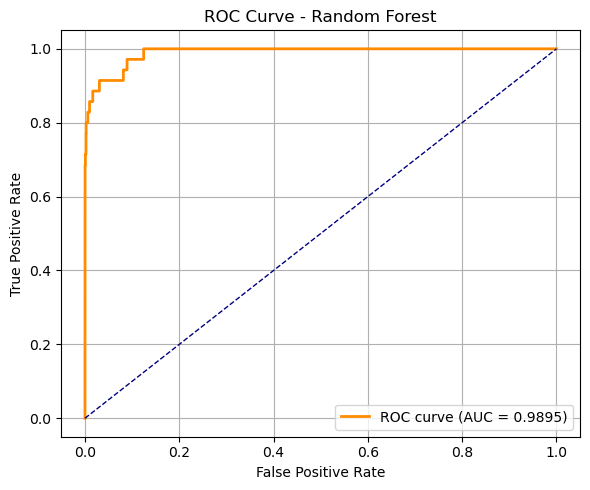

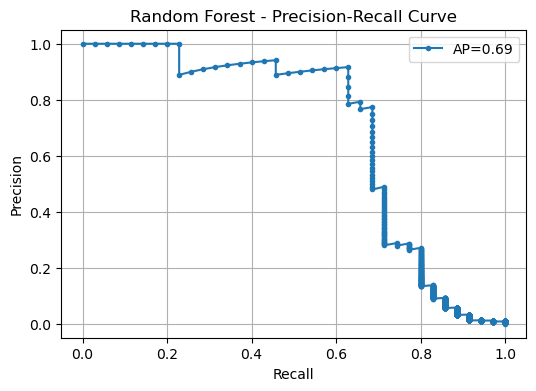

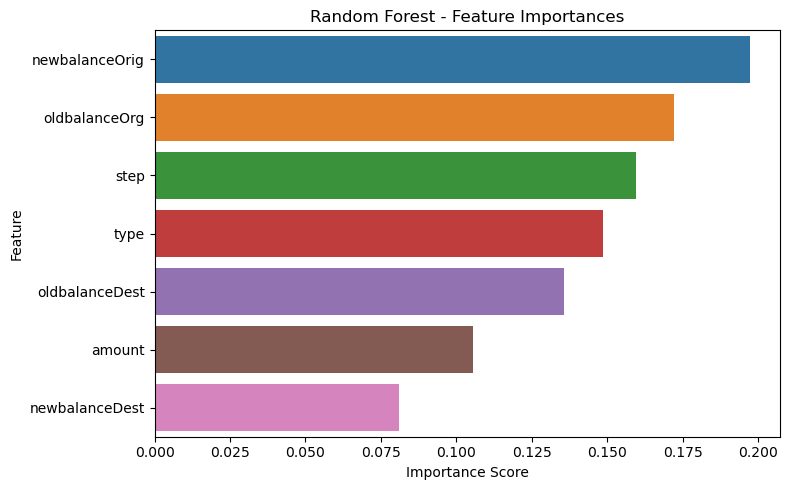

In [18]:
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=5, 
                                  class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# Display classification report
print("=== Random Forest Results ===")
print(classification_report(y_test, rf_preds, digits=4))

# Confusion Matrix for Random Forest
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=["Not Fraud", "Fraud"], 
                yticklabels=["Not Fraud", "Fraud"])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_confusion_matrix(y_test, rf_preds, "Random Forest - Confusion Matrix")




# Predict probabilities
rf_probs = rf_model.predict_proba(X_test)[:, 1]

# Compute ROC-AUC score
roc_auc = roc_auc_score(y_test, rf_probs)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, rf_probs)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Precision-Recall Curve for Random Forest
def plot_precision_recall(y_true, y_scores, title='Precision-Recall Curve'):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    avg_precision = average_precision_score(y_true, y_scores)
    plt.figure(figsize=(6,4))
    plt.plot(recall, precision, marker='.', label=f'AP={avg_precision:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

plot_precision_recall(y_test, rf_model.predict_proba(X_test)[:, 1], "Random Forest - Precision-Recall Curve")

# Feature Importance from Random Forest
importances_rf = rf_model.feature_importances_
feat_names = X.columns
indices = np.argsort(importances_rf)[::-1]

plt.figure(figsize=(8,5))
sns.barplot(x=importances_rf[indices], y=feat_names[indices])
plt.title('Random Forest - Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

C:\Users\Jafar\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:52:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Evaluation Report: XGBoost

[[29962     3]
 [   10    25]]

Classification Report:

              precision    recall  f1-score   support

           0     0.9997    0.9999    0.9998     29965
           1     0.8929    0.7143    0.7937        35

    accuracy                         0.9996     30000
   macro avg     0.9463    0.8571    0.8967     30000
weighted avg     0.9995    0.9996    0.9995     30000

ROC-AUC Score: 0.9873


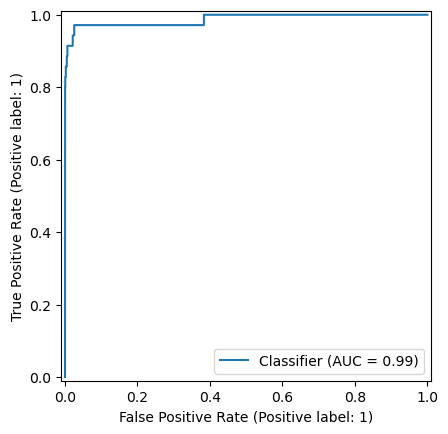

In [19]:
# --- 2. XGBoost ---

xgb_model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate
evaluate_model(y_test, y_pred_xgb, y_proba_xgb, model_name="XGBoost")


In [20]:
# Define parameter grid
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [10, 15]
}

# Initialize base XGBoost model
xgb_base = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Set up Grid Search
xgb_grid = GridSearchCV(estimator=xgb_base, param_grid=xgb_param_grid,
                        scoring='f1', cv=3, verbose=2, n_jobs=-1)

# Fit to training data
xgb_grid.fit(X_train, y_train)

# Best model
xgb_model = xgb_grid.best_estimator_
print("Best Parameters for XGBoost:\n", xgb_grid.best_params_)

# Predict and Evaluate
xgb_preds = xgb_model.predict(X_test)
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]


Fitting 3 folds for each of 64 candidates, totalling 192 fits


C:\Users\Jafar\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:53:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters for XGBoost:
 {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'scale_pos_weight': 15, 'subsample': 1.0}


C:\Users\Jafar\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:53:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== XGBoost Classification Report ===
              precision    recall  f1-score   support

           0     0.9997    0.9999    0.9998     29965
           1     0.8710    0.7714    0.8182        35

    accuracy                         0.9996     30000
   macro avg     0.9354    0.8856    0.9090     30000
weighted avg     0.9996    0.9996    0.9996     30000



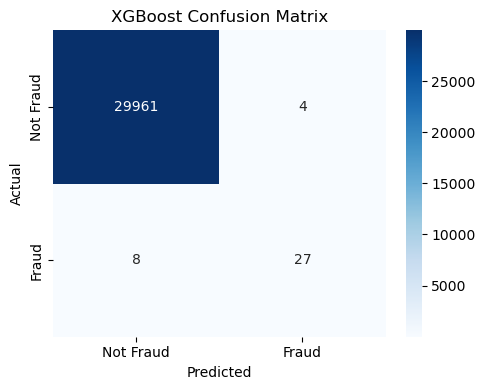

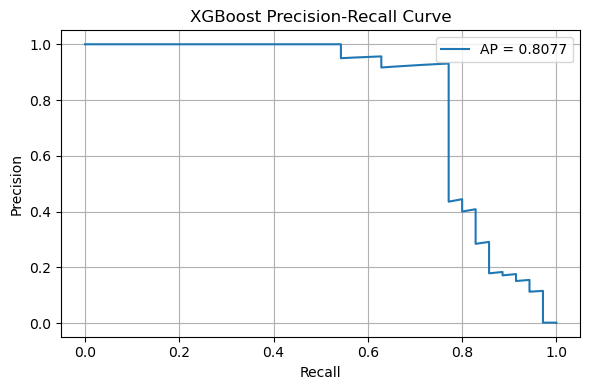

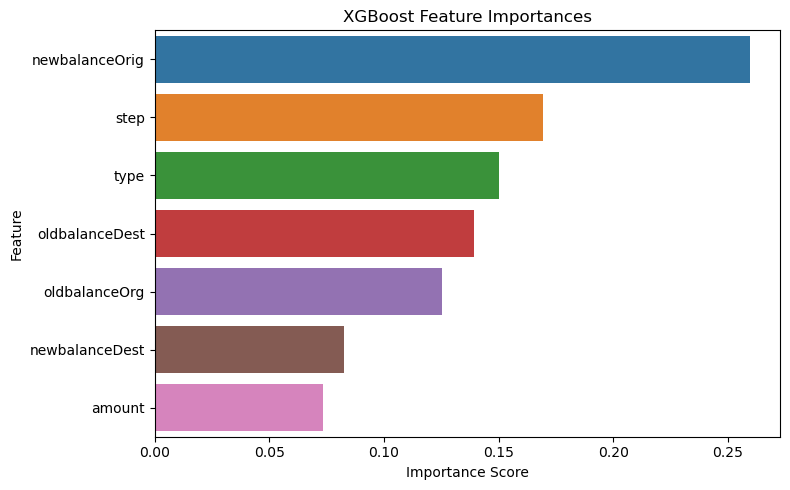

ROC-AUC Score: 0.9803


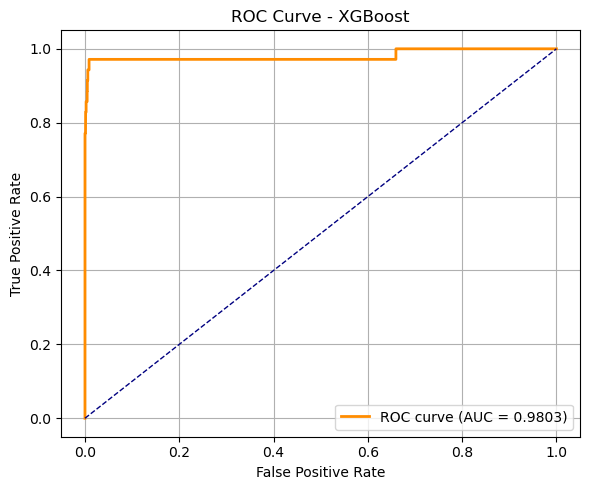

In [21]:
# Define the model with tuned hyperparameters
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=1.0,
    colsample_bytree=0.8,
    scale_pos_weight=15,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
xgb_preds = xgb_model.predict(X_test)
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]


# Evaluation

print("=== XGBoost Classification Report ===")
print(classification_report(y_test, xgb_preds, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, xgb_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, xgb_proba)
avg_precision = average_precision_score(y_test, xgb_proba)

plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f"AP = {avg_precision:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("XGBoost Precision-Recall Curve")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# Feature Importance

importances = xgb_model.feature_importances_
feat_names = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,5))
sns.barplot(x=importances[indices], y=feat_names[indices])
plt.title("XGBoost Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


# ROC-AUC Score & Curve

# Compute ROC-AUC score
roc_auc = roc_auc_score(y_test, xgb_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, xgb_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\Jafar\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(


Evaluation Report: One-Class SVM

[[    0 29965]
 [    0    35]]

Classification Report:

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000     29965
           1     0.0012    1.0000    0.0023        35

    accuracy                         0.0012     30000
   macro avg     0.0006    0.5000    0.0012     30000
weighted avg     0.0000    0.0012    0.0000     30000



C:\Users\Jafar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Jafar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Jafar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


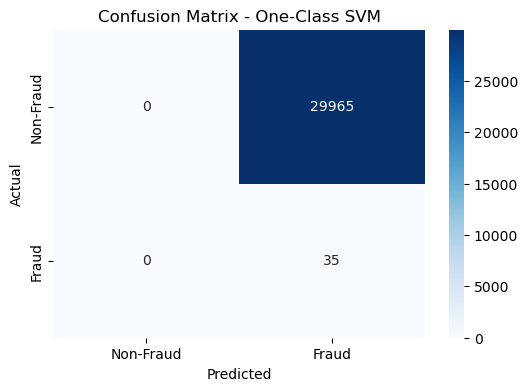

In [22]:
# --- 3. One-Class SVM ---

# Filter only non-fraud (class = 0) for training
X_ocsvm = X[y == 0]

ocsvm_model = OneClassSVM(kernel='rbf', nu=0.01, gamma='scale')
ocsvm_model.fit(X_ocsvm)

# Predict on test set (1 = inliers, -1 = outliers)
y_pred_ocsvm = ocsvm_model.predict(X_test)
y_pred_ocsvm = np.where(y_pred_ocsvm == -1, 1, 0)  # Convert to 1 for fraud

# Evaluate (No proba available for OCSVM)
evaluate_model(y_test, y_pred_ocsvm, model_name="One-Class SVM")

# Confusion Matrix Calculation
cm = confusion_matrix(y_test, y_pred_ocsvm)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix - One-Class SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



In [23]:
# Comparison of Machine Learning Models for Fraud Detection: Random Forest vs XGBoost vs One-Class SVM
# This code compares the performance of Random Forest, XGBoost, and One-Class SVM based on key metrics such as 
# Accuracy, Precision, Recall, F1-Score, and ROC-AUC.

# Model names for comparison
models = ["Random Forest (Before Tuning)", "Random Forest (After Tuning)", 
          "XGBoost (Before Tuning)", "XGBoost (After Tuning)", "One-Class SVM"]


accuracy = [accuracy_score(y_test, y_pred_rf),    # Random Forest (Before Tuning)
            accuracy_score(y_test, rf_preds),      # Random Forest (After Tuning)
            accuracy_score(y_test, y_pred_xgb),   # XGBoost (Before Tuning)
            accuracy_score(y_test, xgb_preds),    # XGBoost (After Tuning)
            accuracy_score(y_test, y_pred_ocsvm)]  # One-Class SVM

precision = [precision_score(y_test, y_pred_rf),
             precision_score(y_test, rf_preds),
             precision_score(y_test, y_pred_xgb),
             precision_score(y_test, xgb_preds),  
             precision_score(y_test, y_pred_ocsvm)]

recall = [recall_score(y_test, y_pred_rf),
          recall_score(y_test, rf_preds),
          recall_score(y_test, y_pred_xgb),
          recall_score(y_test, xgb_preds),  
          recall_score(y_test, y_pred_ocsvm)]  

f1 = [f1_score(y_test, y_pred_rf),
      f1_score(y_test, rf_preds),
      f1_score(y_test, y_pred_xgb),
      f1_score(y_test, xgb_preds),  
      f1_score(y_test, y_pred_ocsvm)]  



# Create a DataFrame
metrics_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    
})

# Function to add arrows and color formatting to the table
def arrow_style(val, baseline_values, column_name):
    baseline = baseline_values[column_name]
    if val > baseline:
        return f'color: green; font-weight: bold; text-align: center;'  # Green for improvement
    elif val < baseline:
        return f'color: red; font-weight: bold; text-align: center;'  # Red for decline
    else:
        return 'text-align: center;'  # No color for no change

def arrow_text(val, baseline_values, column_name):
    baseline = baseline_values[column_name]
    if val > baseline:
        return f'↑ {val:.4f}'  # Adding up arrow for improvement and showing 4 decimal places
    elif val < baseline:
        return f'↓ {val:.4f}'  # Adding down arrow for decrease and showing 4 decimal places
    else:
        return f'→ {val:.4f}'  # No change, right arrow, and showing 4 decimal places

# Set XGBoost (After Tuning) as the baseline
baseline_values = {
    'Accuracy': accuracy[3],
    'Precision': precision[3],
    'Recall': recall[3],
    'F1-Score': f1[3],
    
}

# Apply the styling to the table with arrows and color
metrics_df['Accuracy'] = metrics_df['Accuracy'].apply(lambda x: arrow_text(x, baseline_values, 'Accuracy'))
metrics_df['Precision'] = metrics_df['Precision'].apply(lambda x: arrow_text(x, baseline_values, 'Precision'))
metrics_df['Recall'] = metrics_df['Recall'].apply(lambda x: arrow_text(x, baseline_values, 'Recall'))
metrics_df['F1-Score'] = metrics_df['F1-Score'].apply(lambda x: arrow_text(x, baseline_values, 'F1-Score'))


# Apply the color styling
styled_df = metrics_df.style.applymap(lambda x: arrow_style(float(x.split()[1]), baseline_values, 'Accuracy'), subset=['Accuracy']) \
                          .applymap(lambda x: arrow_style(float(x.split()[1]), baseline_values, 'Precision'), subset=['Precision']) \
                          .applymap(lambda x: arrow_style(float(x.split()[1]), baseline_values, 'Recall'), subset=['Recall']) \
                          .applymap(lambda x: arrow_style(float(x.split()[1]), baseline_values, 'F1-Score'), subset=['F1-Score']) \
                          

# Display the styled DataFrame
styled_df


,Model,Accuracy,Precision,Recall,F1-Score
0,Random Forest (Before Tuning),↓ 0.9993,↑ 0.9412,↓ 0.4571,↓ 0.6154
1,Random Forest (After Tuning),↓ 0.9994,↓ 0.8462,↓ 0.6286,↓ 0.7213
2,XGBoost (Before Tuning),↓ 0.9996,↑ 0.8929,↓ 0.7143,↓ 0.7937
3,XGBoost (After Tuning),→ 0.9996,→ 0.8710,→ 0.7714,→ 0.8182
4,One-Class SVM,↓ 0.0012,↓ 0.0012,↑ 1.0000,↓ 0.0023
